<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/LidarDownload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Lidar Data from USGS 3Dep (Microsoft Planet Computer) 
## This notebook demonstrates how to download point cloud data and other USGS 3dep products from Microsoft's Planetary Computer Catalog and visualize those data in a map and 3d context

### Author: John Hogland 3/8/2023

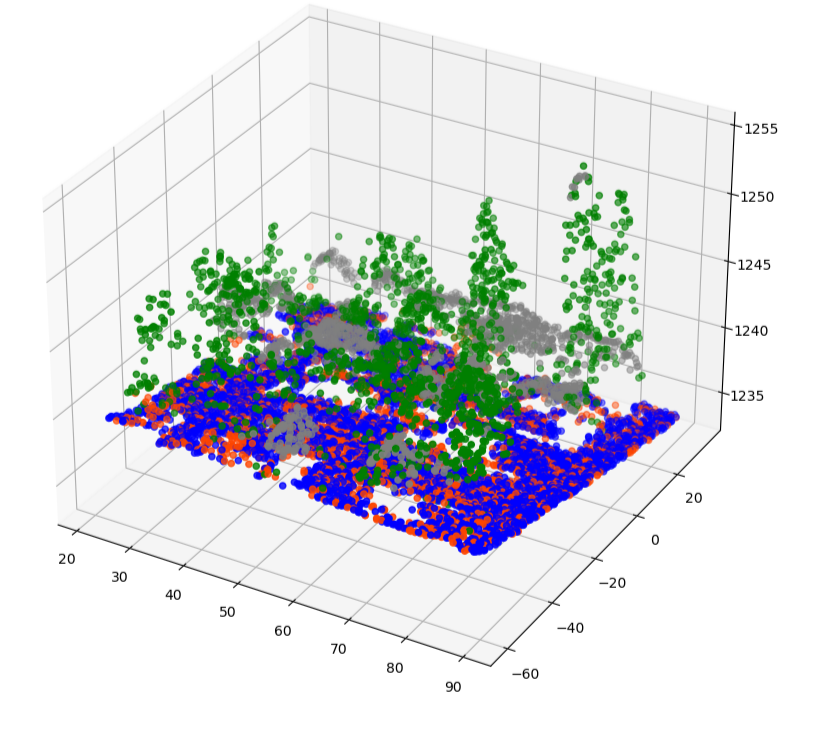

Install packages for Colab

In [3]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install pystac_client
!pip install planetary_computer
!pip install stackstac
!pip install plotly
!pip install laspy[lazrs,laszip]
!pip install raster_tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

# Get supporting python file

In [6]:
import gdown, zipfile

url='https://drive.google.com/file/d/1dy7bnPKc4BPvHlH-PkrObXwb-SW9nv7n/view?usp=sharing'
outfl= r'./rs_las.py'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1dy7bnPKc4BPvHlH-PkrObXwb-SW9nv7n
To: /content/rs_las.py
100%|██████████| 17.5k/17.5k [00:00<00:00, 11.1MB/s]


'./rs_las.py'

# The Process
In this notebook we will look at USGS 3dep products that are publicly available and use raster_tools to perform processing. At each step in the notebook we will discuss various aspects of the data, processing techniques, and visualization. After completing this notebook you should be very familiar with how to use Planetary Computer to retrieve data and how to use raster_tools to perform various spatial analyses.
## Steps
- 1. Create an area of interest (Helena MT; 47.0158° N, 112.1723° W)
- 2. Query Planetary Computer Catalog for Lidar tiles
- 3. Download tiles
- 4. Visualize point cloud data
- 5. Download processed raster derived data from Planetary Computer
- 6. Visualize raster data

## Step 1: Create an area of interest
### Import various packages

In [7]:
import pystac_client
import stackstac
import planetary_computer
import pandas as pd
import geopandas as gpd
import rs_las
from dask.diagnostics import ProgressBar
from IPython.display import display
import laspy
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import requests
import os

### Define the location of interest (Helena MT; 46.595806° N, -112.027031° W) and buffer that location 0.01 degrees
- define point location in lat and lon EPSG:4326 (WGS 84)
- buffer point location by 0.01 degrees to select an area of interest
- look at the footprint of our tile using folium

In [9]:
loc = {"type": "Point", "coordinates": [-112.027, 46.64]}

from shapely.geometry import shape
from shapely.ops import transform

geom = shape(loc)
geom_buff=gpd.GeoSeries(geom.buffer(0.01),crs='EPSG:4326')
geom_buff.explore()

## Step 2: Query Planetary Computer

### Query the catalog using the buffered geometry of our point location (Helena MT)
- search the planetary computer catalog for 3dep point cloud data ("3dep-lidar-copc")
- no token needed
- use geom buffer to select tiles
- retrieve all items

In [10]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

search = catalog.search(collections=["3dep-lidar-copc"], intersects=geom.buffer(0.01))
ic = search.get_all_items()

### Create a geodataframe from the items within the catalog & display the boundary of each lidar tile

In [11]:
df2 = gpd.GeoDataFrame.from_features(ic.to_dict(), crs="epsg:4326")
display(df2.head(5))
p1=geom_buff.explore(color='orange')
p2=df2.explore(m=p1,color='blue')
p2

,geometry,pc:type,datetime,group_id,pc:count,proj:bbox,proj:epsg,pc:schemas,pc:encoding,3dep:usgs_id,end_datetime,proj:geometry,proj:projjson,start_datetime
0,"POLYGON ((-112.02532 46.62261, -112.01356 46.6...",lidar,None,3dep-lidar,2924185,"[421236.686, 5163968.69, 1134.62, 422765.196, ...",None,"[{'name': 'X', 'size': 8, 'type': 'floating'},...",application/vnd.laszip+copc,MT_Helena_2012,2012-05-09T00:00:00Z,"{'type': 'Polygon', 'coordinates': [[[421504.2...",{'name': 'NAD83 / UTM zone 12N + NAVD88 height...,2012-05-08T00:00:00Z
1,"POLYGON ((-112.04381 46.62205, -112.03990 46.6...",lidar,None,3dep-lidar,3927192,"[419736.6388, 5163939.79, 1144.59, 421265.3288...",None,"[{'name': 'X', 'size': 8, 'type': 'floating'},...",application/vnd.laszip+copc,MT_Helena_2012,2012-05-09T00:00:00Z,"{'type': 'Polygon', 'coordinates': [[[420087.1...",{'name': 'NAD83 / UTM zone 12N + NAVD88 height...,2012-05-08T00:00:00Z
2,"POLYGON ((-112.02519 46.63614, -112.01343 46.6...",lidar,None,3dep-lidar,2770284,"[421207.8692, 5165468.834, 1131.33, 422736.479...",None,"[{'name': 'X', 'size': 8, 'type': 'floating'},...",application/vnd.laszip+copc,MT_Helena_2012,2012-05-09T00:00:00Z,"{'type': 'Polygon', 'coordinates': [[[421533.6...",{'name': 'NAD83 / UTM zone 12N + NAVD88 height...,2012-05-08T00:00:00Z
3,"POLYGON ((-112.04380 46.63555, -112.03927 46.6...",lidar,None,3dep-lidar,3533124,"[419707.58, 5165439.91, 1142.95, 421236.41, 51...",None,"[{'name': 'X', 'size': 8, 'type': 'floating'},...",application/vnd.laszip+copc,MT_Helena_2012,2012-05-09T00:00:00Z,"{'type': 'Polygon', 'coordinates': [[[420107.9...",{'name': 'NAD83 / UTM zone 12N + NAVD88 height...,2012-05-08T00:00:00Z
4,"POLYGON ((-112.02504 46.64966, -112.00938 46.6...",lidar,None,3dep-lidar,2862273,"[421178.973, 5166968.856, 1128.02, 422707.523,...",None,"[{'name': 'X', 'size': 8, 'type': 'floating'},...",application/vnd.laszip+copc,MT_Helena_2012,2012-05-09T00:00:00Z,"{'type': 'Polygon', 'coordinates': [[[421564.7...",{'name': 'NAD83 / UTM zone 12N + NAVD88 height...,2012-05-08T00:00:00Z


## Step 3: Download lidar tiles

In [12]:
#create a output folder if it does not already exist

output_folder= './lidar_cloud'
if(not os.path.exists(output_folder)): os.mkdir(output_folder)



In [13]:
# download each tile using requests

for tile in ic:
        url = tile.assets["data"].href
        nm = tile.id + '.copc.laz'
        print('downloading ' + nm)
        r=requests.get(url,allow_redirects=True)
        open(output_folder+'/'+nm,'wb').write(r.content)
        


downloading MT_Helena_2012_000135.copc.laz
downloading MT_Helena_2012_000134.copc.laz
downloading MT_Helena_2012_000109.copc.laz
downloading MT_Helena_2012_000108.copc.laz
downloading MT_Helena_2012_000085.copc.laz


### Make and display the geodataframe of Lidar tile boundaries

In [14]:
%%time
laz_dir = './lidar_cloud'
laz_files_lst=[]
for f in os.listdir(laz_dir):
    if f[-4:]=='.laz': laz_files_lst.append(laz_dir+"/"+f)

gdf=rs_las.build_extents(laz_files_lst)
display(gdf)

,name,pnt_cnt,geometry
0,./lidar_cloud/MT_Helena_2012_000108.copc.laz,3533124,"POLYGON ((419707.580 5165439.910, 419707.580 5..."
1,./lidar_cloud/MT_Helena_2012_000085.copc.laz,2862273,"POLYGON ((421178.973 5166968.856, 421178.973 5..."
2,./lidar_cloud/MT_Helena_2012_000109.copc.laz,2770284,"POLYGON ((421207.869 5165468.834, 421207.869 5..."
3,./lidar_cloud/MT_Helena_2012_000135.copc.laz,2924185,"POLYGON ((421236.686 5163968.690, 421236.686 5..."
4,./lidar_cloud/MT_Helena_2012_000134.copc.laz,3927192,"POLYGON ((419736.639 5163939.790, 419736.639 5..."


CPU times: user 33.3 ms, sys: 3.04 ms, total: 36.3 ms
Wall time: 45.7 ms


### Display the geometry over a base map 

In [15]:
m=gdf.explore(name='Tiles',color='orange',style_kwds={'fill':False})
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(m)
folium.LayerControl().add_to(m)
fs=plugins.Fullscreen()
dr=plugins.Draw()
lc=plugins.LocateControl()
ms=plugins.MeasureControl(position='bottomleft')
msp=plugins.MousePosition()
ms.add_to(m)
msp.add_to(m)
lc.add_to(m)
dr.add_to(m)
fs.add_to(m)
m


## Step 4: Visualize point cloud data for part of the first tile
- look at the point format
- look at the unique classification
- look at the fields

In [16]:
las = laspy.read(laz_files_lst[0])
# hdr = las.header
print(las.header.DEFAULT_POINT_FORMAT)
# print(rs_las.get_crs(las_files_lst[0]))
print(np.unique(las.classification))

list(las.point_format.dimension_names)

<PointFormat(3, 0 bytes of extra dims)>
[ 1  2  4  6  7 10 11]


['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time']

### Convert from point cloud to geodataframe

In [17]:
#Import LAS into numpy array (X=raw integer value x=scaled float value)
xyz=las.xyz
l_atts = {
    'intensity':np.array(las.intensity).transpose(),
    'classification':np.array(las.classification).transpose(),
    'return_number':np.array(las.return_number).transpose(),
    'number_of_returns':np.array(las.number_of_returns).transpose(),
    'scane_angle':np.array(las.scan_angle).transpose()
}

#Transform to pandas DataFrame
lidar_df=gpd.GeoDataFrame(l_atts,geometry=gpd.points_from_xy(xyz[:,0],xyz[:,1],xyz[:,2]),crs=rs_las.get_crs(laz_files_lst[0]))
display(lidar_df)

,intensity,classification,return_number,number_of_returns,scane_angle,geometry
0,109,2,1,1,0,POINT Z (419897.694 5165443.558 1159.760)
1,110,11,1,1,0,POINT Z (419895.654 5165443.238 1159.850)
2,100,2,1,1,0,POINT Z (419893.654 5165442.938 1159.770)
3,116,2,1,1,0,POINT Z (419882.984 5165442.698 1159.940)
4,100,11,1,1,0,POINT Z (419885.004 5165442.998 1159.950)
...,...,...,...,...,...,...
3533119,126,2,1,1,2667,POINT Z (420512.184 5166955.148 1146.770)
3533120,109,11,1,1,2833,POINT Z (420488.784 5166952.838 1146.970)
3533121,85,11,1,1,2833,POINT Z (420474.544 5166952.198 1147.140)
3533122,1,4,1,2,2833,POINT Z (420473.594 5166951.628 1153.670)


### Visualize first 10,000 points in 2d using geopandas plot

<AxesSubplot:>

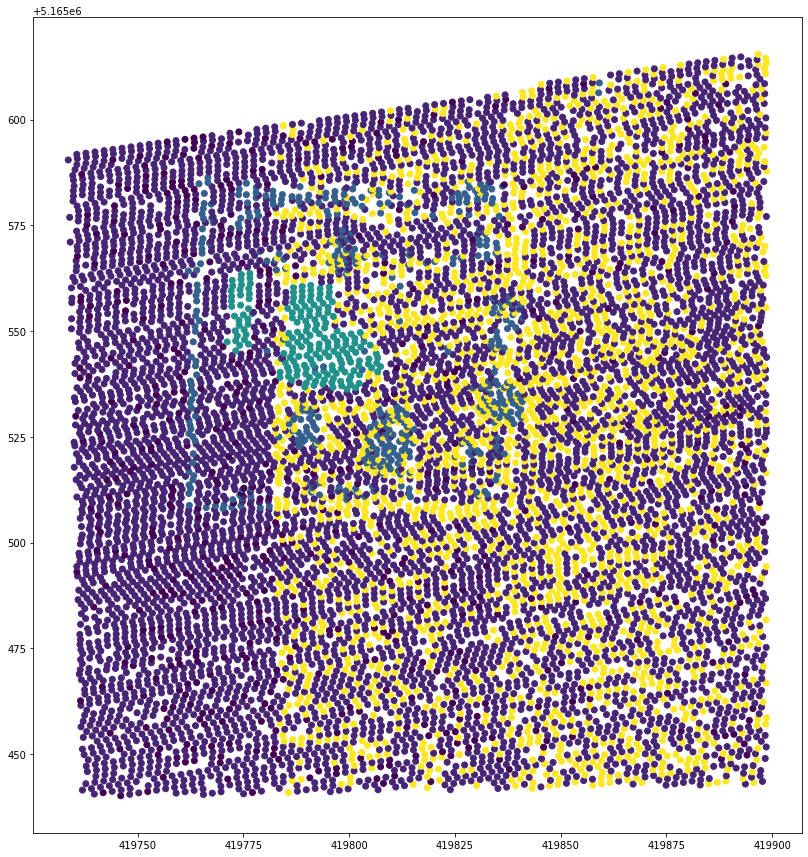

In [18]:
lidar_df.iloc[:10000,:].plot(column='classification', figsize=(15,15))

### Visualize first 10,000 points of the point cloud in 3d using matplotlib

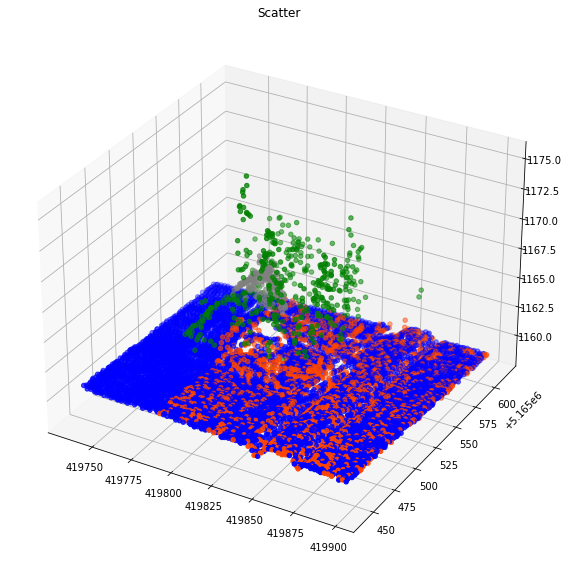

In [19]:
nums= [1,  2,  4, 6,  7, 10, 11]
labs= ['unclassified','ground','medium_veg','building','noise','reserved1','reserved2']
clrs= ['blue','beige','green','grey','purple','orange','orangered']
cmap=ListedColormap(clrs)

fig = plt.figure(figsize=(10,10))
ax3d = fig.add_subplot(projection='3d')
ax3d.scatter(xs=xyz[:10000,0],ys=xyz[:10000,1],zs=xyz[:10000,2],c=lidar_df['classification'][:10000],cmap=cmap)
plt.title("Scatter")
plt.show()

### Visualize first 10,000 points from the point cloud in interactive display (plotly)

In [20]:
l_sub=lidar_df.iloc[:10000]
cdic={nums[i]: clrs[i] for i in range(len(nums))}
fig = px.scatter_3d(l_sub,x=l_sub.geometry.x,y=l_sub.geometry.y,z=l_sub.geometry.z,color='classification',color_discrete_map=cdic,width=1600, height=800)
fig.show()

## Step 5: Download processed rasters
### 3dep program process point cloud data to create common metrics and [Planetary Computer](https://planetarycomputer.microsoft.com/catalog?filter=3dep) hosts those surface as GeoTiffs
- Intensity: 3dep-lidar-intensity
- Returns: 3dep-lidar-returns
- Classification: 3dep-lidar-Classification
- Point Source: 3dep-lidar-pointsourceid
- Digital Surface: 3dep-lidar-dsm
- Digital Terrain: 3dep-lidar-dtm
- Height Above Ground: 3dep-lidar-hag
- Digital Terrain Model: 3dep-lidar-dtm-native

### Search Planetary Computer for 3dep product in the Helena Area for the height above ground ("3dep-lidar-hag").

In [21]:
srch_hag = catalog.search(collections=["3dep-lidar-hag"], intersects=geom.buffer(0.01))
ic_hag = srch_hag.get_all_items()
df_hag = gpd.GeoDataFrame.from_features(ic_hag.to_dict(), crs="epsg:4326")
display(df_hag.head(5))
p1=geom_buff.explore(color='orange')
p2=df_hag.explore(m=p1,color='blue')
p2

,geometry,datetime,proj:epsg,proj:shape,3dep:usgs_id,end_datetime,raster:bands,proj:geometry,proj:projjson,proj:transform,start_datetime
0,"POLYGON ((-112.04648 46.65336, -112.04506 46.5...",None,None,"[4097, 4097]",MT_Helena_2012,2012-05-09T00:00:00Z,"{'unit': 'metre', 'nodata': 'nan', 'sampling':...","{'type': 'Polygon', 'coordinates': [[[-112.046...",{'name': 'NAD83 / UTM zone 12N + NAVD88 height...,"[2.0, 0.0, 419929.0, 0.0, -2.0, 5167175.0, 0, ...",2012-05-08T00:00:00Z


### Create a xarray stack using stakstac
- remove the time aspect from the stack
- convert it to a Raster Object


In [35]:
import raster_tools
ds=(stackstac.stack(planetary_computer.sign(ic_hag),epsg='EPSG:4326',bounds_latlon=geom_buff.total_bounds))[0]
ds=ds.rio.write_crs(4326, inplace=True)
rs=raster_tools.Raster(ds) #note we are removing the time aspect of the stack here since there is only one time step
rs=rs.set_crs('EPSG:4326')
rs.xrs

<ipython-input-35-6270f8a760dd>:6: DeprecationWarning:

'Raster.xrs' is deprecated. It will soon be removed. Use xdata.



<xarray.DataArray 'raster' (band: 1, y: 1099, x: 757)>
dask.array<where, shape=(1, 1099, 757), dtype=float64, chunksize=(1, 1024, 757), chunktype=numpy.ndarray>
Coordinates: (12/17)
    time            datetime64[ns] NaT
    id              <U25 'MT_Helena_2012-hag-2m-2-2'
  * band            (band) int64 1
  * x               (x) float64 -112.0 -112.0 -112.0 ... -112.0 -112.0 -112.0
  * y               (y) float64 46.65 46.65 46.65 46.65 ... 46.63 46.63 46.63
    proj:shape      object {4097}
    ...              ...
    proj:epsg       object None
    3dep:usgs_id    <U14 'MT_Helena_2012'
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-112.0464827...
    title           <U8 'COG data'
    epsg            <U9 'EPSG:4326'
    spatial_ref     int64 0
Attributes:
    _FillValue:  -999999.0

## Step 6: Visualize raster data with boundary selection boundary

<ipython-input-36-7e05621d9beb>:2: DeprecationWarning:

'Raster.xrs' is deprecated. It will soon be removed. Use xdata.



RuntimeError: ignored

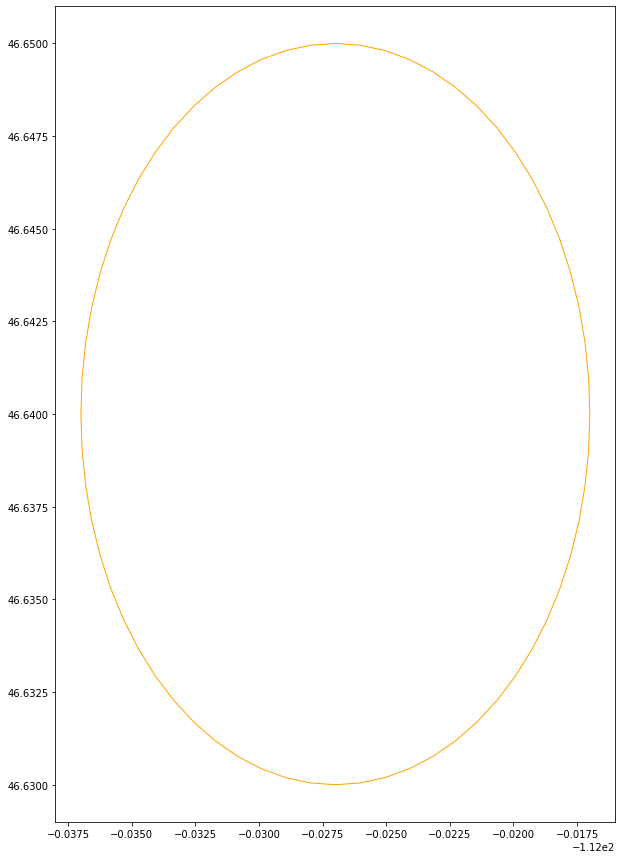

In [36]:
p1=geom_buff.plot(facecolor="none",edgecolor='orange',figsize=(15,15),zorder=1)
p2=rs.xrs.plot(ax=p1,robust=True,zorder=0)

### Save as tif

In [37]:
rs.save('./lidar_cloud/hag.tif')

RuntimeError: ignored

# This ends the Get Lidar ata from USGS 3Dep notebook
## Check out the other notebooks:
- https://github.com/jshogland/SpatialModelingTutorials/tree/main/Notebooks
## References
- Spatial Modeling Notebooks:  https://github.com/jshogland/SpatialModelingTutorials
- Raster-Tools GitHub: https://github.com/UM-RMRS/raster_tools
- Hogland's Spatial Solutions: https://sites.google.com/view/hoglandsspatialsolutions/home
- Dask: https://dask.org/
- Geopandas:https://geopandas.org/en/stable/
- Xarray: https://docs.xarray.dev/en/stable/
- Jupyter: https://jupyter.org/
- Anaconda:https://www.anaconda.com/
- VS Code: https://code.visualstudio.com/
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/
- numpy:https://numpy.org/
- matplotlib:https://matplotlib.org/
- folium: https://python-visualization.github.io/folium/
- pandas: https://pandas.pydata.org/
- sklearn: https://scikit-learn.org/stable/index.html